In [2]:
import IPython
import math
import matplotlib.pyplot as plt
import joblib
import numpy as np
import numpy.matlib
import pandas as pd
import pickle
import pydot
import pylab
import random
import scipy 
import scipy.cluster.hierarchy as shc
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import tabulate
import boto3
import io
from io import StringIO

from numpy import linalg
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.integrate import *
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform 
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, r2_score, make_scorer, mean_squared_error, mean_absolute_error,roc_curve,accuracy_score,roc_auc_score,brier_score_loss, precision_score, recall_score,f1_score, log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

ModuleNotFoundError: No module named 'statsmodels'

# Credit Scoring de créditos hipotecarios

Generalmente se cree que la probabilidad de incumplimiento es una cantidad que puede ser como una etiqueta y que esa misma etiqueta puede usarse para definir tasas de productos (pricing), análisis temporal o credit scoring. En este trabajo se definarán los pasos para llegar a este último.

## 1. Objetivo:

Propuesta de credit scoring mediante el análisis de probabilidad de default (o de incumplimiento) de créditos hipotecarios de Estados Unidos, mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

## 2. Datos:

Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

## 3. Desarrollo:

Adecuando impresión a $3$ dígitos

In [19]:
np.set_printoptions(precision=3, suppress=True)

### Conexión a instancia *S3*

Definimos los parámetros para conectarnos a S3

In [20]:
s3client = boto3.client(
    's3',
    region_name='us-east-1'
)

Asignación del nombre del bucket de S3 y de los datos

In [21]:
bucketname = "bucket-mno-2020-v3"
file_to_read = "data_t_final.csv"

Definimos objeto de S3 para conectarnos

In [22]:
fileobj = s3client.get_object(
    Bucket=bucketname,
    Key=file_to_read
    )

### Lectura y preparación de datos

Lectura del archivo

In [23]:
filedata = fileobj['Body'].read()

Decodificación del archivo

In [24]:
contenido = filedata.decode('utf-8')

In [25]:
type(contenido)

str

Conversión a dataframe

In [26]:
StringData = StringIO(contenido)

In [27]:
df = pd.read_csv(StringData)

In [31]:
df.head(5)

id  time  orig_time  first_time  mat_time  res_time  balance_time  \
0   4    25         -2          25       119       NaN      61031.10   
1   4    26         -2          25       119       NaN      60882.42   
2   4    27         -2          25       119       NaN      60729.80   
3   4    28         -2          25       119       NaN      60576.14   
4   4    29         -2          25       119       NaN      60424.39   

    LTV_time  interest_rate_time  rate_time  ...  FICO_orig_time  \
0  33.911009              10.500        5.9  ...             587   
1  34.007232              10.500        5.9  ...             587   
2  34.335349              10.500        5.9  ...             587   
3  34.672545              10.875        5.9  ...             587   
4  34.951639              10.875        5.9  ...             587   

   LTV_orig_time  Interest_Rate_orig_time  state_orig_time  hpi_orig_time  \
0           81.8                     10.5               KY          97.99   
1           81.8                     10.5               KY          97.99   
2           81.8                     10.5               KY          97.99   
3           81.8                     10.5               KY          97.99   
4           81.8                     10.5               KY          97.99   

   default_time  payoff_time  status_time  lgd_time  recovery_res  
0             0            0            0       NaN           NaN  
1             0            0            0       NaN           NaN  
2             0            0            0       NaN           NaN  
3             0            0            0       NaN           NaN  
4             0            0            0       NaN           NaN  

[5 rows x 28 columns]

### Limpieza de base de datos

Eliminamos valores faltantes

In [32]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

Filtramos los datos de originación dado que el score es para originar créditos. Rerodemos que la variable dependiente es "default_time"

In [33]:
# PREPARAMOS LA BASE PARA CREDIT SCORING
# AQUI USAREMOS SOLO DATOS DE ORIGINACION POR QUE EL SCORE ES PARA ORIGINAR CREDITOS
# LA VARIABLE DEPENDIENTE ES default_time

data2 = data[["id","REtype_CO_orig_time","REtype_PU_orig_time","REtype_SF_orig_time",
              "investor_orig_time",
              "balance_orig_time",
              "FICO_orig_time",
              "LTV_orig_time",
              "Interest_Rate_orig_time",
              "state_orig_time",
              "hpi_orig_time",
              "default_time"]]

Filtramos los créditos con default_time = 1

In [34]:
data_default = data2[(data2.default_time == 1)]

Filtramos los datos que no hicieron default

In [35]:
data_no_default_aux = data2[~data2.id.isin(data_default.id.values)]
data_no_default = data_no_default_aux.drop_duplicates(subset = ["id"])

Utilizamos la función append para unir las bases de forma vertical

In [36]:
data_score = data_default.append(data_no_default)

In [37]:
data_score.head(5)

id  REtype_CO_orig_time  REtype_PU_orig_time  REtype_SF_orig_time  \
47     9                    0                    0                    1   
174   72                    0                    0                    1   
190  100                    0                    0                    1   
232  111                    0                    0                    1   
263  191                    0                    0                    1   

     investor_orig_time  balance_orig_time  FICO_orig_time  LTV_orig_time  \
47                    0           128000.0             501           80.0   
174                   0           129500.0             536           69.6   
190                   0            88000.0             556           80.0   
232                   0           227000.0             622           64.9   
263                   0           227200.0             630           80.0   

     Interest_Rate_orig_time state_orig_time  hpi_orig_time  default_time  
47                     8.000              GA         186.91             1  
174                    7.605              FL         226.29             1  
190                    7.810              OH         208.86             1  
232                    7.325              NY         208.86             1  
263                    7.360              FL         221.91             1

### Modelo

### Cálculo Weight of **Evidence** (*WOE*) y **IV** (*IV*)

In [44]:
def woe(data_in, target, variable, bins, binning):
    """
    Cómputo del Weight of Evidence (woe)
    
    input:
    - data_in(df): dataframe con las variables necesarias para el cálculo
    - target(str): variable target
    - variable(str): variable
    - bins(float): definición de intervalos de corte
    - binning(boolean): indicadora para calcular o no los intervalos de corte
    output:
    
    """
    
    df = data_in
    
    # Selección de variables y eliminar valores faltantes
    df2 = data_in[[target, variable]].rename(columns={target: 'Target', variable: 'Variable'}).dropna()
    
    # Cálculo de intervalos del tipo: "(a, b]"
    if binning:
       df2['key'] = pd.qcut(df2.Variable, bins, labels=False, duplicates='drop')
    else:
       df2['key'] = df2.Variable
    
    # Tabla cruzada para observaciones default y no default
    table = pd.crosstab(df2.key, df2.Target, margins= True)
    table = table.drop(['All'], axis=0)
    table = table.rename(columns={1: 'deft', 0: 'nondeft'}).reset_index(drop=False)
    
    # Agregar frecuencia relativa de default y no default
    table.loc[:, 'fracdeft'] = table.deft/np.sum(table.deft)
    table.loc[:, 'fracnondeft'] = table.nondeft/np.sum(table.nondeft)
    
    # Cálculo del WOE y del IV
    table.loc[:, 'WOE'] = np.log(table.fracdeft/table.fracnondeft)
    table.loc[:, 'IV'] = (table.fracdeft-table.fracnondeft)*table.WOE
    
    # Renombrar variables
    table.rename(columns={'WOE': variable}, inplace=True)
    table=table.add_suffix('_WOE')
    table.rename(columns={table.columns[0]: 'key' }, inplace = True)
    
    # Construcción de dataset WOE
    WOE = table.iloc[:, [0,-2]]
    df = pd.merge(df, df2.key, right_index=True, left_index=True)
    outputWOE = pd.merge(df, WOE, on='key').drop(['key'], axis=1)
    #outputWOE = pd.merge(df, WOE, on='key')
    outputIV = pd.DataFrame(data={'name': [variable], 'IV': table.IV_WOE.sum()})
    
    return outputWOE, outputIV

In [51]:
data_score, outputIV1 = woe(data_in = data_score, target='default_time', variable = 'balance_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV2 = woe(data_in = data_score, target='default_time', variable = 'FICO_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV3 = woe(data_in = data_score, target='default_time', variable = 'LTV_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV4 = woe(data_in = data_score, target='default_time', variable = 'Interest_Rate_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV5 = woe(data_in = data_score, target='default_time', variable = 'hpi_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV6 = woe(data_in = data_score, target='default_time', variable = 'REtype_CO_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV7 = woe(data_in = data_score, target='default_time', variable = 'REtype_PU_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV8 = woe(data_in = data_score, target='default_time', variable = 'REtype_SF_orig_time', 
                            bins=5, binning = 'False')

In [52]:
data_score.tail(5)

id  REtype_CO_orig_time  REtype_PU_orig_time  REtype_SF_orig_time  \
4991  37983                    0                    0                    1   
4992  44886                    0                    0                    0   
4993  33510                    1                    0                    0   
4994   7025                    0                    0                    1   
4995  31079                    0                    0                    1   

      investor_orig_time  balance_orig_time  FICO_orig_time  LTV_orig_time  \
4991                   0           196000.0             694           70.0   
4992                   0           178500.0             696           70.0   
4993                   0           255000.0             702           65.6   
4994                   1           400000.0             689           67.8   
4995                   0           635000.0             690           64.8   

      Interest_Rate_orig_time state_orig_time  ...  REtype_PU_orig_time_WOE_y  \
4991                    7.000              FL  ...                        0.0   
4992                    7.625              NY  ...                        0.0   
4993                    7.125              MD  ...                        0.0   
4994                    7.875              NC  ...                        0.0   
4995                    7.000              CA  ...                        0.0   

      REtype_SF_orig_time_WOE_y  balance_orig_time_WOE  FICO_orig_time_WOE  \
4991                        0.0               0.090269           -0.020037   
4992                        0.0               0.090269           -0.020037   
4993                        0.0               0.137896           -0.020037   
4994                        0.0              -0.035383           -0.020037   
4995                        0.0              -0.035383           -0.020037   

      LTV_orig_time_WOE  Interest_Rate_orig_time_WOE  hpi_orig_time_WOE  \
4991          -0.586728                     0.414387           0.803007   
4992          -0.586728                     0.414387           0.803007   
4993          -0.586728                     0.414387           0.803007   
4994          -0.586728                     0.414387           0.803007   
4995          -0.586728                     0.414387           0.803007   

      REtype_CO_orig_time_WOE  REtype_PU_orig_time_WOE  \
4991                      0.0                      0.0   
4992                      0.0                      0.0   
4993                      0.0                      0.0   
4994                      0.0                      0.0   
4995                      0.0                      0.0   

      REtype_SF_orig_time_WOE  
4991                      0.0  
4992                      0.0  
4993                      0.0  
4994                      0.0  
4995                      0.0  

[5 rows x 36 columns]

In [49]:
#data_score.LTV_orig_time_WOE.unique()

A continuación se muestran los **IV** previamente calculados

In [53]:
print(pd.concat([outputIV1, outputIV2, outputIV3, outputIV4, outputIV5, outputIV6, outputIV7, outputIV8]).\
      round(decimals=4))

                      name      IV
0        balance_orig_time  0.0098
0           FICO_orig_time  0.0899
0            LTV_orig_time  0.0744
0  Interest_Rate_orig_time  0.1238
0            hpi_orig_time  0.5513
0      REtype_CO_orig_time  0.0000
0      REtype_PU_orig_time  0.0000
0      REtype_SF_orig_time  0.0000


Cabe mencionar que para la gran mayoría de las variables de interés el **IV** es muy bajo a excepción de:
1. `hpi_orig_time`
1. `Interest_Rate_orig_time`
1. `LTV_orig_time`
1. `FICO_orig_time`

En general, se tiene la siguiente clasificación del **IV** en relación a su poder predictivo:
* **Muy bajo** si $\text{IV} \in (0, 0.02]$
* **Poder débil** si $\text{IV} \in (0.02, 0.1]$
* **Poder moderado** si $\text{IV} \in (0.1, 0.3]$
* **Fuerte** si $\text{IV} > 0.3$

Por lo que, concluímos que:
1. `hpi_orig_time`.- tiene **fuerte poder** predictivo
1. `Interest_Rate_orig_time`.- tiene **poder moderado** predictivo
1. `LTV_orig_time`.- tiene **poder débil** predictivo
1. `FICO_orig_time`.- tiene **poder débil** predictivo

Para las demás variables, el poder predictivo es **muy bajo**.

Para el análisis, se excluirán las variables que tengan un **muy bajo** poder predictivo, pues no ayudarán a completar el objetivo de este estudio.

### Obtención del modelo y del respectivo score

Para esta parte se utilizará un modelo de **regresión logística** tomando en cuanta las variables que más ayudan a clasificar si un préstamo es default o no. Estas variables deben ser las que son originadas al momento de efectuar el préstamo (`orig_time`), pues queremos saber si dicho préstamo será o no default. Además, se utilizará la evidencia de dicha variable para predecir si el préstamo es o no default, los cuales ya fueron calculados previamente.

* *FICO-WOE*
* *LTV-WOE*
* *Tasa de interés (interest rate)*
* *HPI*

Selección de features (variables) para el modelo

In [59]:
data_score_regresion = data_score[["id","default_time", 
                         "FICO_orig_time_WOE", 
                         "LTV_orig_time_WOE", 
                         "Interest_Rate_orig_time_WOE", 
                         "hpi_orig_time_WOE"]]

Obtención del modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html)

In [61]:
model_score = smf.glm('default_time ~ FICO_orig_time_WOE + LTV_orig_time_WOE + \
                      Interest_Rate_orig_time_WOE + hpi_orig_time_WOE', 
                      family = sm.families.Binomial(), data = data_score_regresion).fit()

A continuación se analizarán los coeficientes y *p-value* de cada feature obtenidos del modelo.

In [348]:
# Aqui hay que analizar los p values y los coeficientes
# por ejemplo, coeficientes, negativos implica que la variable afecta al default en sentido contrario
print(model_score.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                 4996
Model:                            GLM   Df Residuals:                     4991
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2703.1
Date:                Tue, 01 Dec 2020   Deviance:                       5406.2
Time:                        22:22:44   Pearson chi2:                 4.92e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

De la tabla anterior, observamos que todas las variables tienen un coeficiente positivo, por los que incrementos en cada una de ellos tendrán un efecto (no directamente proporcional) positivo en la estimación de la probabilidad para determinar si un préstamo caerá en default o no.



### Resultados

Utilizamos el modelo obtenido a todo el *dataset* 

In [63]:
PD_logit_model_score = pd.DataFrame(model_score.fittedvalues, columns=['PD_logit_model_score'])

In [67]:
PD_logit_model_score

PD_logit_model_score
0                 0.225274
1                 0.225274
2                 0.225274
3                 0.225274
4                 0.225274
...                    ...
4991              0.397876
4992              0.397876
4993              0.397876
4994              0.397876
4995              0.397876

[4996 rows x 1 columns]

Juntamos la información obtenida con el modelo y con el `label` correponsdiente al default

In [68]:
data2_score = pd.merge(data_score_regresion[['id', 'default_time']],PD_logit_model_score, 
                       right_index=True, left_index=True)

In [69]:
data2_score

id  default_time  PD_logit_model_score
0         9             1              0.225274
1      2651             1              0.225274
2     26671             1              0.225274
3      5408             0              0.225274
4     12984             0              0.225274
...     ...           ...                   ...
4991  37983             1              0.397876
4992  44886             0              0.397876
4993  33510             0              0.397876
4994   7025             0              0.397876
4995  31079             0              0.397876

[4996 rows x 3 columns]

In [71]:
def validation(fit, outcome , time, continuous=False):
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.rcParams.update({'font.size': 16})
    
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    if isinstance(fit, pd.Series):
        fit=fit.values
    if isinstance(outcome, pd.Series):
        outcome=outcome.values
    if isinstance(time, pd.Series):
        time=time.values
    
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    means = data_in.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
  
    data_in['outcomeD']=data_in.loc[:,'outcome']    
    if continuous==True:
        data_in.loc[data_in['outcome'] >= data_in.outcome.mean(), 'outcomeD'] = 1
        data_in.loc[data_in['outcome'] <  data_in.outcome.mean(), 'outcomeD'] = 0
    
    outcomeD=data_in.loc[:,'outcomeD'].values

    lr_log_loss = np.nan
    roc_auc = np.nan
    brier = np.nan
    binom_p = np.nan
    Jeffreys_p =  np.nan
    
    max_outcome_fit=np.maximum(max(outcome), max(fit))
    min_outcome_fit=np.minimum(min(outcome), min(fit)) 
    if min_outcome_fit>=0 and max_outcome_fit<=1:
        lr_log_loss = log_loss(outcomeD, fit).round(4)
        roc_auc = roc_auc_score(outcomeD, fit).round(4)
        binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p= np.mean(fit), alternative='greater').round(decimals=4)
        Jeffreys_p =  beta.cdf(np.mean(fit), sum(outcomeD)+0.5, len(outcomeD)-sum(outcomeD)+0.5).round(decimals=4)

            
    corr,_=pearsonr(fit,outcome)
    r2_OLS=corr**2
    
    the_table = [['Counts', len(outcome)],
                      ['Mean outcome', (sum(outcome)/len(outcome)).round(4)],
                      ['Mean fit', np.mean(fit).round(4)],
                      ['AUC ', roc_auc],
                      ['R-squared (OLS)', round(r2_OLS,4)],
                      ['R-squared', r2_score(outcome, fit).round(decimals=4)],
                      ['RMSE/ SQR(Brier score)', round(np.sqrt(((outcome-fit).dot(outcome-fit))/len(outcome)),4)],
                      ['Log loss', lr_log_loss], 
                      ['Binomial p-value', binom_p],
                      ['Jeffreys p-value', Jeffreys_p]]
    the_table=pd.DataFrame(data=the_table)
    the_table.columns = ['Metric', 'Value']
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
 
    plt.subplot(221)
    plt.title('Summary')
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center', 
                   colWidths=[0.34, 0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(16) 
    test.scale(2, 1.5)
    
    plt.subplot(222)
    plt.title('Time-Series Real-Fit')
    plt.plot(means['time'],means['outcome'])
    plt.plot(means['time'],means['fit'], color='red', ls='dashed')
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Mean', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(('Outcome','Fit'), loc='best', fontsize=15)
    
    plt.subplot(223)
    plt.title('Fit Histogram')
    plt.hist(fit, bins=20, histtype='bar', density=True)
    plt.xlabel('Fit', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    
    data_in['cat'] = pd.qcut(data_in.fit, 10, labels=False, duplicates='drop')
    real_fit = data_in.groupby('cat')[['fit', 'outcome']].mean()
    mpv=real_fit.fit.values
    fop=real_fit.outcome.values
    
    maximum=np.maximum(max(fop), max(mpv))       
    maximum=np.ceil(maximum*100)/100
    minimum=np.minimum(min(fop), min(mpv))
    minimum=np.floor(minimum*100)/100
    
    plt.subplot(224)
    plt.title('Calibration Curve')
    plt.plot(mpv, fop, marker='.', linestyle='', markersize=18)
    plt.plot([minimum,maximum],[minimum,maximum], linestyle='--', color='gray')
    plt.xlim((minimum,maximum))
    plt.ylim((minimum,maximum))
    plt.xlabel('Mean fit', fontsize=15)
    plt.ylabel('Mean outcome', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.show()    

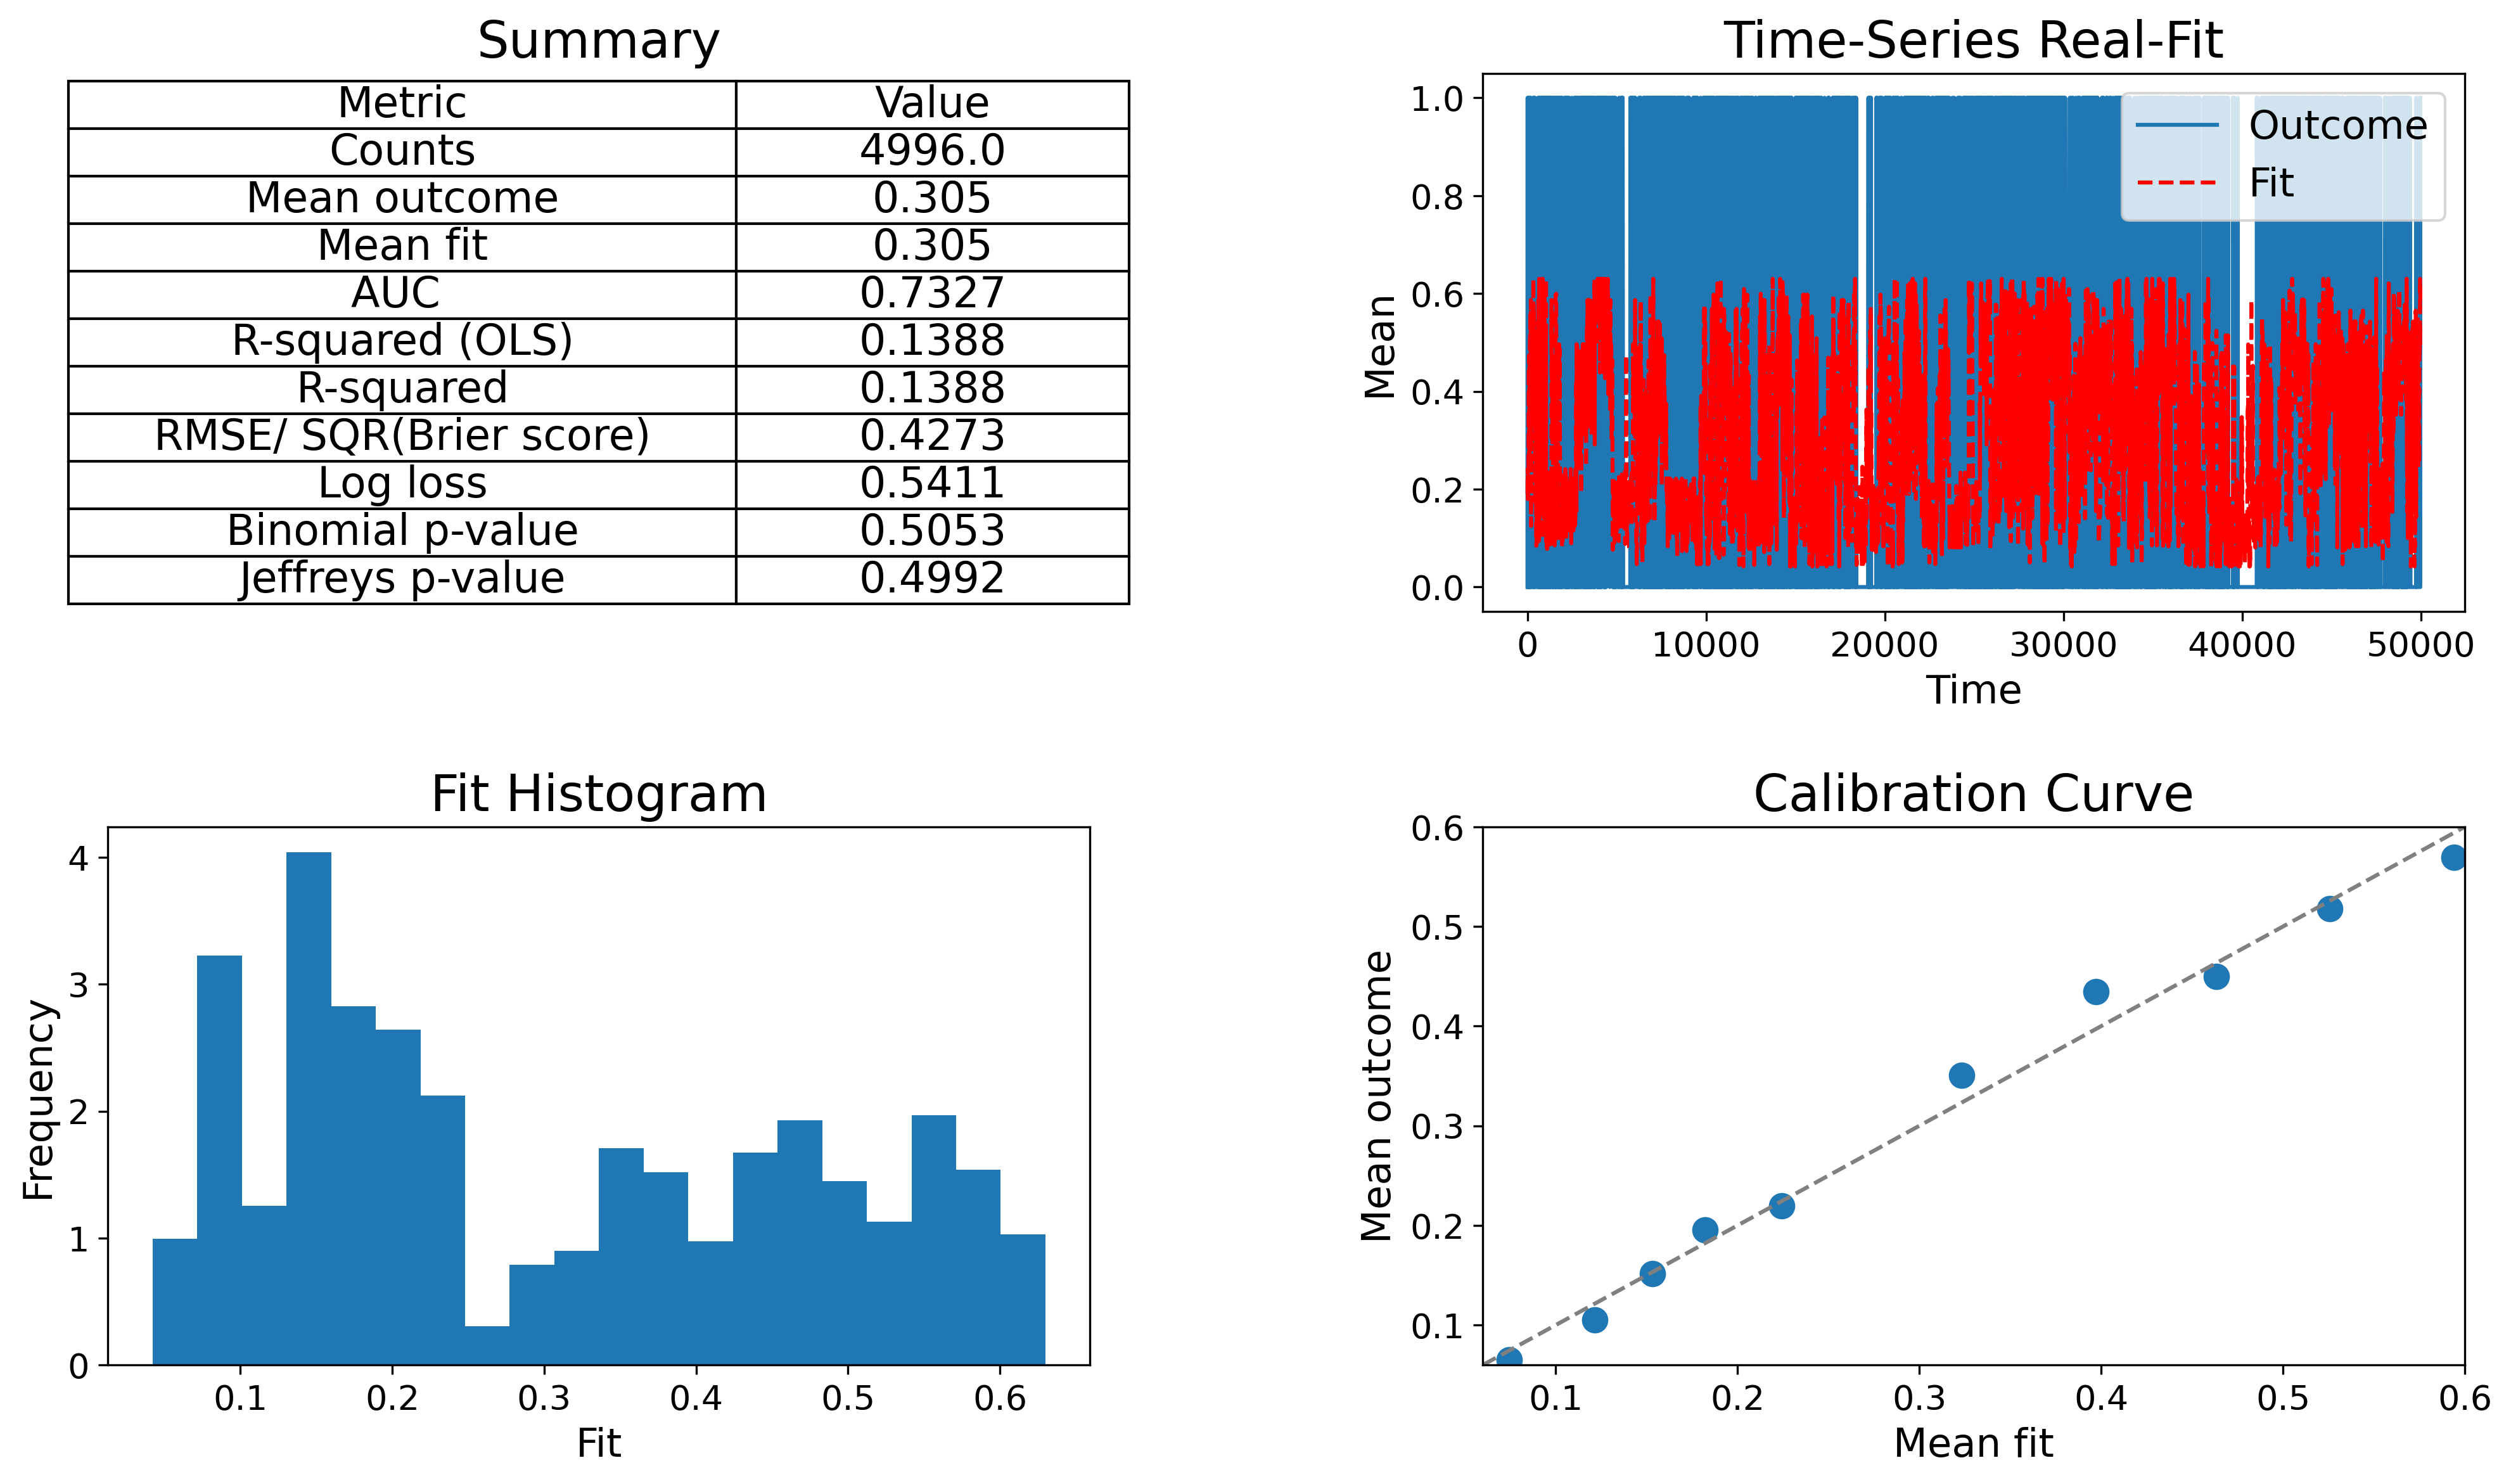

In [72]:
validation(data2_score.PD_logit_model_score, data2_score.default_time, data2_score.id)